# Introduction - Dense Timeseries Change Detection

Change detection is a *hot* topic within the Earth Observation (EO) community, particular since the release of the landsat archive and more recently the availablity of the  ESA Sentinel-1 and 2 data.

There are several approaches to change detection and these can be categorised as:

- Map-to-Map
- Image-to-Image
- Map-to-Image
- Dense Timeseries

These approaches have different advances and disadvantages and this tutorial will demonstrate the implementation of a method for each type.

## What is Dense Timeseries Analysis?

Dense timeseries methods are a **form of image-to-image methods** in that image pixel values are being compared. However, the assumptions and properties of these methods can be quite different. For example, rather than seasonability being noise causing false changes to be found it is a single which is used to identify change. These methods are typically more **computationally complex**, and therefore **time consuming** when compared to other methods, while also **requiring a singnificant amount of data** to work. These methods will usually fit some form of model to the data and predict image pixel values. 

## What are the steps:

This kind of analysis is complex and can be very computationally intensive - hense the very small subset of data we are using. The first step is to fit a model to each pixel in the timeseries. Then we can 

# 1. Define Imports

In [1]:
%matplotlib inline

import os

import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import rsgislib.imagecalc
import rsgislib.imagecalc.calcindices
import rsgislib.imageutils
import rsgislib.rastergis
import rsgislib.tools.mapping
from rsgislib.timeseries import modelfitting

# 2. Define Input Files and Directories

In [2]:
# A JSON file which specifies the order and acquasition dates
# of the input images
sen2_imgs_lut = "05_timeseries_imgs.json"

timeseries_chg_dir = "timeseries_chg"
if not os.path.exists(timeseries_chg_dir):
    os.mkdir(timeseries_chg_dir)

# 3. Fit the timeseries model

In [3]:
coeffs_img = os.path.join(timeseries_chg_dir, "timeseries_mdl_coeffs.kea")

# All the input images need to have the same number of image bands
# we will however only use a subset of the bands to fit the model
# in this case bands 3 (Red), 7 (NIR) and 9 (SWIR1).
modelfitting.get_ST_model_coeffs(
    sen2_imgs_lut, coeffs_img, bands=[3, 7, 9], num_processes=1
)

  0%|          | 0/100 [00:00<?, ?it/s]

# 4. Predict an Output image

Use the model we have fitted we can now use that model to predict an output image. 


In [4]:
pred_refl_test_img = os.path.join(timeseries_chg_dir, "sen2_pred_img_test.kea")

modelfitting.predict_for_date("2017-07-15", coeffs_img, pred_refl_test_img)

  0%|          | 0/100 [00:00<?, ?it/s]

# 5. Visualise Predicted Image

Image Data Size: 169 x 140
Image Data Size: 169 x 140


Text(0.5, 1.0, 'Predicted Image')

/Users/pfb/miniconda3/envs/osgeo-env-v9/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


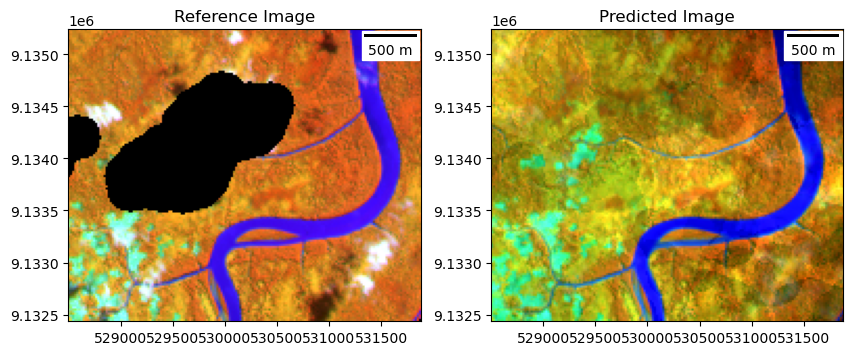

In [5]:
ref_refl_img = "../data/chg_data/timeseries_sen2/SEN2_20170715_lats77lone395_T37MEM_ORB049_utm37s_vmsk_mclds_topshad_rad_srefdem_stdsref.kea"

# Create the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Plot the input reference image
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    ref_refl_img,
    img_bands=[7, 9, 3],
    img_stch=rsgislib.IMG_STRETCH_CUMULATIVE,
    show_scale_bar=True,
)
ax1.set_title("Reference Image")


# Plot the input reference image
rsgislib.tools.mapping.create_raster_img_map(
    ax2,
    pred_refl_test_img,
    img_bands=[2, 3, 1],
    img_stch=rsgislib.IMG_STRETCH_CUMULATIVE,
    show_scale_bar=True,
)
ax2.set_title("Predicted Image")

# 6. Predict an Image into the Future.

In this case we are predicting an image into the future, as the model is fitted to data from 2016 to 2018 but the image we are predicting will be for 2019-06-10.

In [6]:
pred_refl_img = os.path.join(timeseries_chg_dir, "sen2_pred_img_20190610.kea")

modelfitting.predict_for_date("2019-06-10", coeffs_img, pred_refl_img)

  0%|          | 0/100 [00:00<?, ?it/s]

Image Data Size: 169 x 140


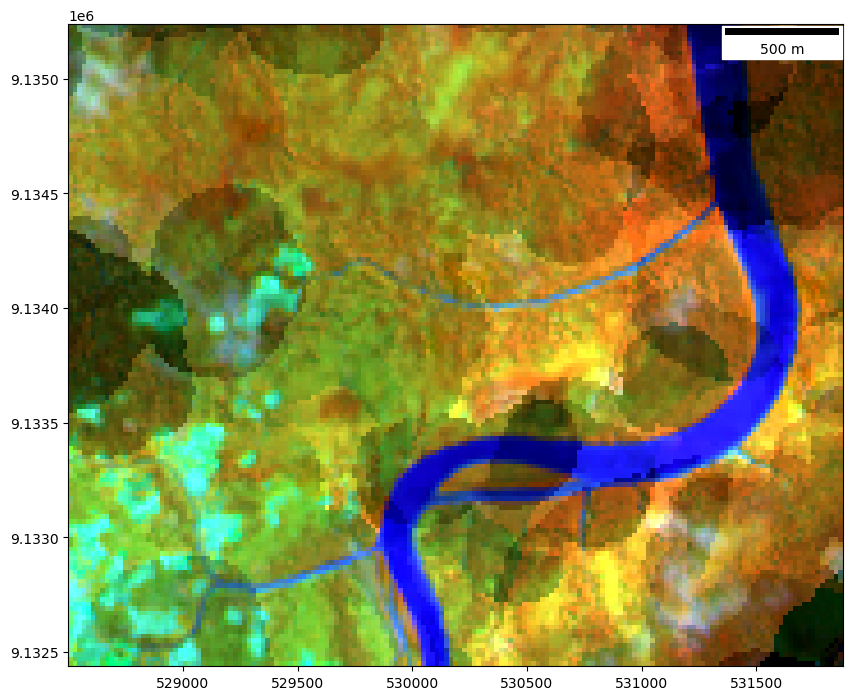

In [7]:
# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the input reference image
rsgislib.tools.mapping.create_raster_img_map(
    ax,
    pred_refl_img,
    img_bands=[2, 3, 1],
    img_stch=rsgislib.IMG_STRETCH_CUMULATIVE,
    show_scale_bar=True,
)

# 7. Calculate Change

## 7.1 Define Input Image

In [8]:
sen2_img_20190610 = "../data/chg_data/timeseries_sen2/SEN2_20190610_lats77lone395_T37MEM_ORB049_utm37s_vmsk_mclds_topshad_rad_srefdem_stdsref.kea"

## 7.2 Calculate NDVI

In [9]:
pred_ndvi_img = os.path.join(timeseries_chg_dir, "sen2_pred_img_20190610_ndvi.kea")
rsgislib.imagecalc.calcindices.calc_ndvi(pred_refl_img, 1, 2, pred_ndvi_img)

sen2_ndvi_img = os.path.join(timeseries_chg_dir, "sen2_img_20190610_ndvi.kea")
rsgislib.imagecalc.calcindices.calc_ndvi(sen2_img_20190610, 3, 7, sen2_ndvi_img)

Image: timeseries_chg/sen2_pred_img_20190610.kea
	 Variable 'red' is band 1
	 Variable 'nir' is band 2
New image width = 169 height = 140 bands = 1



Calculating Image Pyramids.

Image: ../data/chg_data/timeseries_sen2/SEN2_20190610_lats77lone395_T37MEM_ORB049_utm37s_vmsk_mclds_topshad_rad_srefdem_stdsref.kea
	 Variable 'red' is band 3
	 Variable 'nir' is band 7
New image width = 169 height = 140 bands = 1



Calculating Image Pyramids.



## 7.3 Visualise NDVI Images

Image Data Size: 169 x 140
Image Data Size: 169 x 140


Text(0.5, 1.0, 'Predicted NDVI')

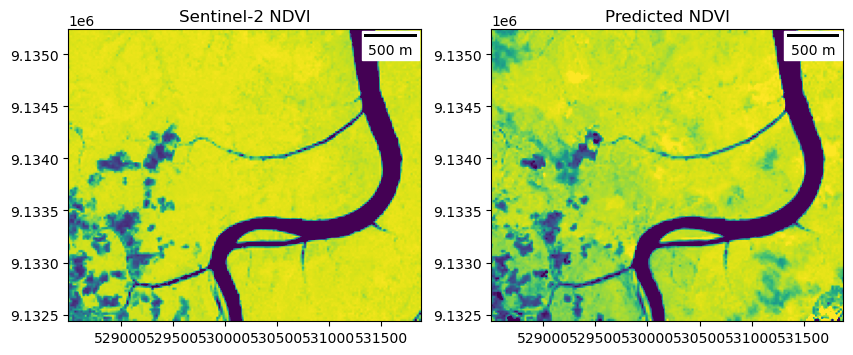

In [10]:
# Create the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Plot the sen2 reference ndvi
rsgislib.tools.mapping.create_raster_cmap_img_map(
    ax1,
    sen2_ndvi_img,
    img_band=1,
    cmap_name="viridis",
    norm_img_vals=True,
    norm_vmin=0.15,
    norm_vmax=0.95,
    show_scale_bar=True,
)
ax1.set_title("Sentinel-2 NDVI")

# Plot the sen2 predicted ndvi
rsgislib.tools.mapping.create_raster_cmap_img_map(
    ax2,
    pred_ndvi_img,
    img_band=1,
    cmap_name="viridis",
    norm_img_vals=True,
    norm_vmin=0.15,
    norm_vmax=0.95,
    show_scale_bar=True,
)
ax2.set_title("Predicted NDVI")

## 7.4 Calculate NDVI Difference

In [11]:
ndvi_diff_img = os.path.join(timeseries_chg_dir, "ndvi_diff_act_pred.kea")

band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("ndvi_pred", pred_ndvi_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("ndvi_act", sen2_ndvi_img, 1))

exp = "ndvi_pred-ndvi_act"

rsgislib.imagecalc.band_math(
    ndvi_diff_img, exp, "KEA", rsgislib.TYPE_32FLOAT, band_defns
)

rsgislib.imageutils.pop_img_stats(
    ndvi_diff_img, use_no_data=False, no_data_val=0, calc_pyramids=True
)

Image: timeseries_chg/sen2_img_20190610_ndvi.kea
	 Variable 'ndvi_act' is band 1
Image: timeseries_chg/sen2_pred_img_20190610_ndvi.kea
	 Variable 'ndvi_pred' is band 1
New image width = 169 height = 140 bands = 1



Calculating Image Pyramids.



## 7.5 Visualise NDVI Difference

Image Data Size: 169 x 140


(<matplotlib.colors.ListedColormap at 0x329270b00>,
 <matplotlib.colors.Normalize at 0x3293e19a0>)

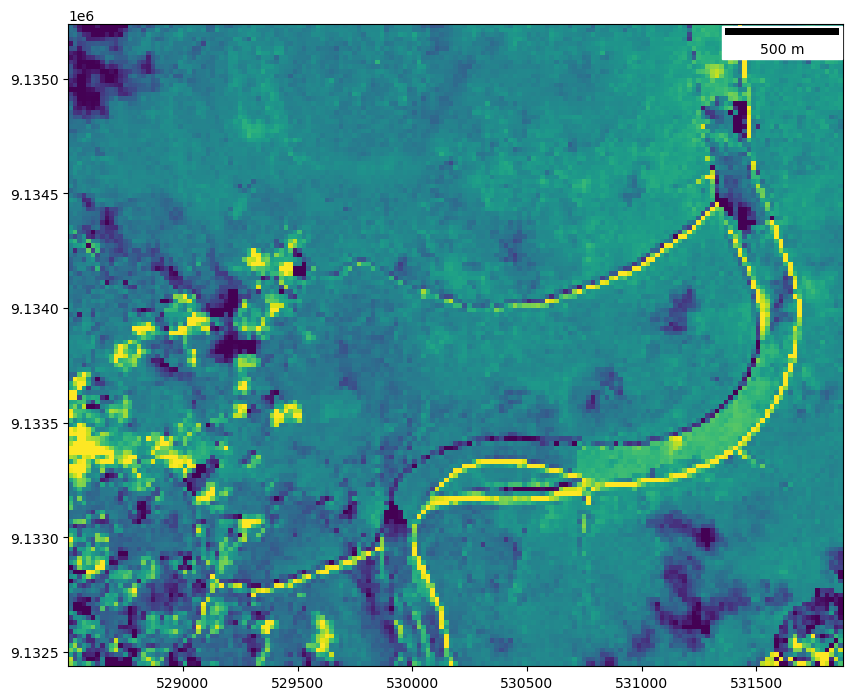

In [12]:
# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the ndvi difference
rsgislib.tools.mapping.create_raster_cmap_img_map(
    ax,
    ndvi_diff_img,
    img_band=1,
    cmap_name="viridis",
    norm_img_vals=True,
    norm_vmin=-0.3,
    norm_vmax=0.3,
    show_scale_bar=True,
)

## 7.6 Calculate Change Features

In [13]:
change_feats_img = os.path.join(timeseries_chg_dir, "change_feats.kea")

band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("ndvi_diff", ndvi_diff_img, 1))

exp = "ndvi_diff>0.3?1:ndvi_diff<-0.3?2:0"

rsgislib.imagecalc.band_math(
    change_feats_img, exp, "KEA", rsgislib.TYPE_8UINT, band_defns
)

rsgislib.rastergis.pop_rat_img_stats(
    change_feats_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

Image: timeseries_chg/ndvi_diff_act_pred.kea
	 Variable 'ndvi_diff' is band 1
New image width = 169 height = 140 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



## 7.7 Apply Colours and Names

In [14]:
class_info_dict = dict()
class_info_dict[1] = {
    "classname": "Pos NDVI Chng",
    "red": 255,
    "green": 0,
    "blue": 0,
}
class_info_dict[2] = {
    "classname": "Neg NDVI Chng",
    "red": 0,
    "green": 0,
    "blue": 255,
}

rsgislib.rastergis.set_class_names_colours(
    change_feats_img, "class_names", class_info_dict
)

## 7.8 Visualise Change Features

Image Data Size: 169 x 140


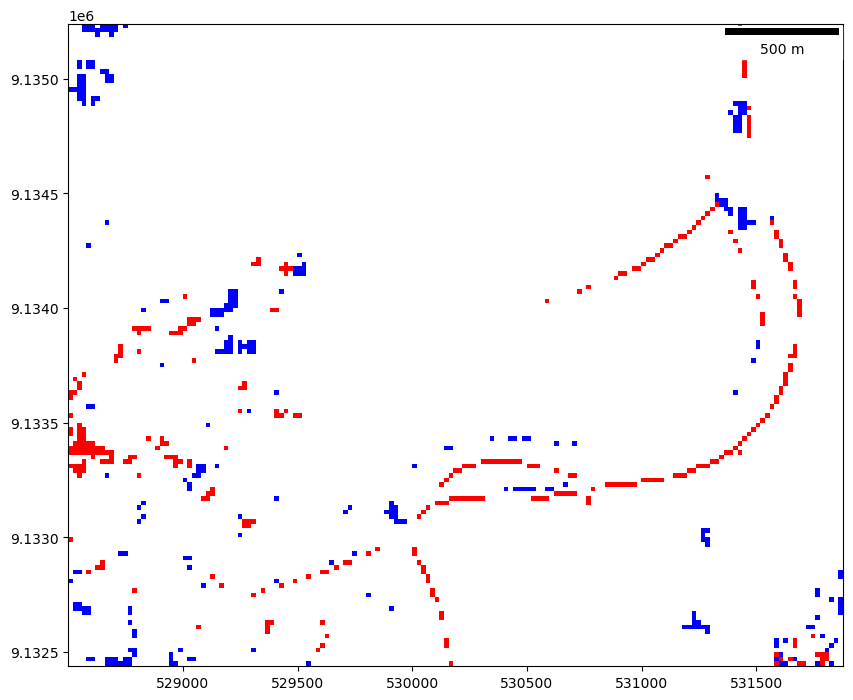

In [15]:
# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot change map
rsgislib.tools.mapping.create_thematic_raster_map(ax, change_feats_img)